## Week 14 Workshop

In this week we will continue working with small molecules and chemical language models. First we will calculate similarities between molecules using traditional methods. Then we will do semantic search using embeddings from chemical language models.

We begin by importing all the dependencies.

In [1]:
import pandas as pd
import pyarrow.parquet as pq

from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import MolToSmiles

from transformers import AutoModel, AutoTokenizer
import torch

from sklearn.metrics.pairwise import cosine_similarity

## Molecule similarities

Traditionally, molecule similarities are calculated with fingerprints. Here, we will calculate fingerprints for two closely related molecules and then use them to calculate a distance. The example is taken in part from [this post](https://greglandrum.github.io/rdkit-blog/posts/2025-07-17-naming-similarity-metrics.html) on the RDKit blog.

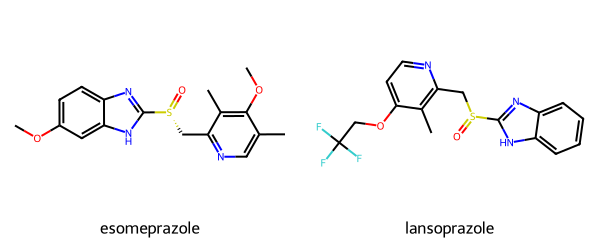

In [2]:
esomeprazole = Chem.MolFromSmiles('COc1ccc2nc([nH]c2c1)[S@](=O)Cc1ncc(C)c(OC)c1C')
lansoprazole = Chem.MolFromSmiles('FC(F)(F)COc1ccnc(c1C)CS(=O)c2[nH]c3ccccc3n2')
Draw.MolsToGridImage([esomeprazole, lansoprazole], 
    legends=['esomeprazole','lansoprazole'], molsPerRow=2, subImgSize=(300, 250))



We are calculating [Morgan fingerprints,](https://pubs.acs.org/doi/pdf/10.1021/c160017a018) which are long binary vectors that represent the presence of absence of specific structural features in a molecule. These fingerprints can then be converted into similarity scores using the [Tanimoto similarity,](https://en.wikipedia.org/wiki/Jaccard_index) which is the ratio of the intersection of the two fingerprints to their union.

In [3]:
mfp_fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2)
mfp = [mfp_fpg.GetFingerprint(mol) for mol in [esomeprazole, lansoprazole]]
print('Morgan fingerprint similarity:', DataStructs.TanimotoSimilarity(mfp[0], mfp[1]))


Morgan fingerprint similarity: 0.4264705882352941


If we want to, we can visualize the actual fingerprints.

In [4]:
def bit_vect_to_string(fp):
    set_bits = list(fp.GetOnBits())
    binary_string = ''.join(['1' if i in set_bits else '0' for i in range(fp.GetNumBits())])
    return binary_string

print(bit_vect_to_string(mfp[0]))
print(bit_vect_to_string(mfp[1]))

0000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000010000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000100000000001000000000100000000000000000000000000000100001000000000000000000000000000000000000000000000000100000000000000000000000000000000001000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000010000000000000000000000000000000000000000000010000000000000000000000100000000000000000000000000000000010000000000000000000000000000100000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000010000000000000000100000000000000000000000000010000000000

## Changing SMILES canonicalization

Our eventual goal in this worksheet is to perform embedding-based similarity search as discussed in [Kosonocky et al. 2023.](https://www.cell.com/patterns/fulltext/S2666-3899(23)00249-0) As in that paper, we canonicalize SMILES strings using RDKit. Embeddings are calculated using ChemBERTa. But before we can go there, we have to discuss how to change canonicalization.

First we load a dataset of known compounds with canonical SMILES. This dataset was generated in notebook `week14-preprocessing.ipynb`.



In [5]:

compounds = pd.read_csv("data/Canonical_SMILES.csv")
compounds

,Name,SMILES,Target,SMILES_Canonical
0,"1,2-Benzodiazepine",N1N=CC=CC2=CC=CC=C12,NaN,C1=Cc2ccccc2NN=C1
1,"1,2-Distearoyllecithin",CCCCCCCCCCCCCCCCCC(=O)OCC(COP([O-])(=O)OCC[N+]...,NaN,CCCCCCCCCCCCCCCCCC(=O)OCC(COP(=O)([O-])OCC[N+]...
2,"1,2-icosapentoyl-sn-glycero-3-phosphoserine",[H]C(N)(COP(O)(=O)OCC([H])(COC(=O)CCC\C=C/C\C=...,NaN,CC/C=C\C/C=C\C/C=C\C/C=C\C/C=C\CCCCC(=O)OC(COC...
3,1-Palmitoyl-2-oleoyl-sn-glycero-3-(phospho-rac...,CCCCCCCCCCCCCCCC(=O)OC[C@H](COP(O)(=O)OCC(O)CO...,NaN,CCCCCCCC/C=C\CCCCCCCC(=O)O[C@H](COC(=O)CCCCCCC...
4,"2,2'-Dibenzothiazyl disulfide",S(SC1=NC2=CC=CC=C2S1)C1=NC2=CC=CC=C2S1,NaN,c1ccc2sc(SSc3nc4ccccc4s3)nc2c1
...,...,...,...,...
2578,alpha-Linolenic acid,CC\C=C/C\C=C/C\C=C/CCCCCCCC(O)=O,Prostaglandin G/H synthase 1;Aromatase;Peroxis...,CC/C=C\C/C=C\C/C=C\CCCCCCCC(=O)O
2579,alpha-Tocopherol succinate,[H][C@@](C)(CCCC(C)C)CCC[C@@]([H])(C)CCC[C@]1(...,NaN,Cc1c(C)c2c(c(C)c1OC(=O)CCC(=O)O)CC[C@@](C)(CCC...
2580,gamma-Aminobutyric acid,NCCCC(O)=O,Sodium- and chloride-dependent GABA transporte...,NCCCC(=O)O
2581,gamma-Hydroxybutyric acid,OCCCC(O)=O,Sodium- and chloride-dependent GABA transporte...,O=C(O)CCCO


Now we pick one molecule as our search query. We are going to use morphine.

In [6]:
molecule_row = compounds[compounds['Name'] == 'Morphine'].iloc[0]
print(f"Chosen molecule SMILES: \n{molecule_row}")

Chosen molecule SMILES: 
Name                                                         Morphine
SMILES              [H][C@@]12OC3=C(O)C=CC4=C3[C@@]11CCN(C)[C@]([H...
Target              Mu-type opioid receptor;Kappa-type opioid rece...
SMILES_Canonical    CN1CC[C@]23c4c5ccc(O)c4O[C@H]2[C@@H](O)C=C[C@H...
Name: 1586, dtype: object


Let's draw the molecular structure, using both the original SMILES and the canoncial SMILES strings as input. As you can see, the structure is the same (though the output can be rotated or flipped).

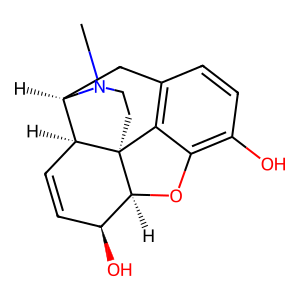

In [7]:
# original SMILES string from the FDA database
mol = Chem.MolFromSmiles(molecule_row['SMILES'])
Draw.MolToImage(mol)

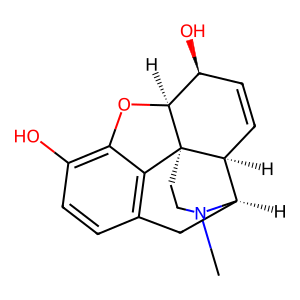

In [8]:
mol = Chem.MolFromSmiles(molecule_row['SMILES_Canonical'])
Draw.MolToImage(mol)

Now we explore different canonicalizations of the query molecule. We can do this with RDKit. Various options args exist for editing the SMILES generation, [see here.](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html)

First, we can root at any of the atoms.

In [9]:
for atom in range(mol.GetNumAtoms()):
    smiles_example = MolToSmiles(mol, canonical=False, rootedAtAtom=atom)
    print(f"SMILES rooted at atom {atom+1}: \n{smiles_example}\n")

SMILES rooted at atom 1: 
CN1CC[C@]23c4c5ccc(O)c4O[C@H]2[C@@H](O)C=C[C@H]3[C@H]1C5

SMILES rooted at atom 2: 
N1(C)CC[C@]23c4c5ccc(O)c4O[C@H]2[C@@H](O)C=C[C@H]3[C@H]1C5

SMILES rooted at atom 3: 
C1N(C)[C@H]2[C@H]3[C@@]4(C1)c1c(ccc(O)c1O[C@H]4[C@@H](O)C=C3)C2

SMILES rooted at atom 4: 
C1CN(C)[C@H]2[C@H]3[C@]14c1c(ccc(O)c1O[C@H]4[C@@H](O)C=C3)C2

SMILES rooted at atom 5: 
[C@]123CCN(C)[C@H]4[C@@H]1C=C[C@H](O)[C@@H]2Oc1c3c(ccc1O)C4

SMILES rooted at atom 6: 
c12c3ccc(O)c1O[C@@H]1[C@]24CCN(C)[C@@H]([C@@H]4C=C[C@@H]1O)C3

SMILES rooted at atom 7: 
c12c3c(c(O)cc1)O[C@@H]1[C@]34CCN(C)[C@@H]([C@@H]4C=C[C@@H]1O)C2

SMILES rooted at atom 8: 
c1c2c3c(c(O)c1)O[C@@H]1[C@]34CCN(C)[C@@H]([C@@H]4C=C[C@@H]1O)C2

SMILES rooted at atom 9: 
c1cc2c3c(c1O)O[C@@H]1[C@]34CCN(C)[C@@H]([C@@H]4C=C[C@@H]1O)C2

SMILES rooted at atom 10: 
c1(O)ccc2c3c1O[C@@H]1[C@]34CCN(C)[C@@H]([C@@H]4C=C[C@@H]1O)C2

SMILES rooted at atom 11: 
Oc1ccc2c3c1O[C@@H]1[C@]34CCN(C)[C@@H]([C@@H]4C=C[C@@H]1O)C2

SMILES rooted at atom 12: 

We can set `isomericSmiles=False` to remove stereochemistry.

In [10]:
smiles_example = MolToSmiles(mol, isomericSmiles=False)
print(f"Altered SMILES string with `isomericSmiles=False`: \n{smiles_example}\n")


Altered SMILES string with `isomericSmiles=False`: 
CN1CCC23c4c5ccc(O)c4OC2C(O)C=CC3C1C5



We can also randomize the SMILES string.

In [11]:
smiles_example = Chem.MolToSmiles(mol, doRandom=True)
print(f"Randomized SMILES string: \n{smiles_example}\n")

Randomized SMILES string: 
CN1CC[C@]23[C@H]4C=C[C@H](O)[C@@H]3Oc3c(O)ccc(c32)C[C@H]41



We can use kekule form, which represents double bonds explicitly with equals signs.

In [12]:
smiles_example = Chem.MolToSmiles(mol, kekuleSmiles=True)
print(f"Kekule form SMILES string: \n{smiles_example}\n")

Kekule form SMILES string: 
CN1CC[C@]23C4=C5C=CC(O)=C4O[C@H]2[C@@H](O)C=C[C@H]3[C@H]1C5



## Chemical Semantic Search (CheSS) 

Now we are ready to perform embedding-based similarity search (chemical semantic search) as discussed in [Kosonocky et al. 2023.](https://www.cell.com/patterns/fulltext/S2666-3899(23)00249-0) Embeddings are calculated using ChemBERTa. We will be working with a preprocessed dataset where embeddings have already been calculated. See notebook `week14-preprocessing.ipynb` for details.

We begin by loading the ChemBERTa model.

In [13]:
tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")
model = AutoModel.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")  

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
model.to(device)

Skipping import of cpp extensions due to incompatible torch version 2.9.1 for torchao version 0.14.1             Please see https://github.com/pytorch/ao/issues/2919 for more info
W1209 10:56:56.756000 41511 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(52000, 768, padding_idx=1)
    (position_embeddings): Embedding(512, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-5): 6 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (drop

Calculate embeddings for Morphine using OEChem SMILES and RDKit canonical SMILES and calculate their cosine similarity.

In [14]:
# Morphine canonicalized with RDkit
canonical_smiles_example = compounds[compounds['Name'] == 'Morphine']['SMILES_Canonical'].values[0]

# morphine in OEChem format (pulled from pubchem, https://pubchem.ncbi.nlm.nih.gov/compound/5288826)
OEChem_smiles_example = "CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)O)O[C@H]3[C@H](C=C4)O"

print(f"Example OEChem SMILES: {OEChem_smiles_example}")
print(f"Example Canonical SMILES: {canonical_smiles_example}")

# encode with model
inputs = tokenizer(OEChem_smiles_example, return_tensors="pt")
# inputs to device
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
embedding_OEChem_example = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

# canonical smiles embedding from parquet
inputs = tokenizer(canonical_smiles_example, return_tensors="pt")
# inputs to device
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
embedding_canonical_example = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

canonical_similarity = cosine_similarity(embedding_OEChem_example, embedding_canonical_example)
print(f"Cosine similarity between OEChem and canonical embedding: {canonical_similarity[0][0]:.4f}")

Example OEChem SMILES: CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)O)O[C@H]3[C@H](C=C4)O
Example Canonical SMILES: CN1CC[C@]23c4c5ccc(O)c4O[C@H]2[C@@H](O)C=C[C@H]3[C@H]1C5
Cosine similarity between OEChem and canonical embedding: 0.9385


Search precalculated database of embeddings (calculated with canonical SMILES) using OEChem embeddings of Morphine as the query.

In [15]:
# load embeddings from parquet
table = pq.read_table('data/Canonical_SMILES_embeddings_BPE.parquet')
embeddings_all = table.to_pandas().values

# compute cosine similarities
similarities = cosine_similarity(embedding_OEChem_example, embeddings_all)

# get top 5 most similar
top5_indices = similarities[0].argsort()[-5:][::-1]
print("Top 5 most similar drugs:")
for idx in top5_indices:
    print(f"Name: {compounds.iloc[idx]['Name']}, Similarity: {similarities[0][idx]:.4f}, Target: {compounds.iloc[idx]['Target']}")

Top 5 most similar drugs:
Name: Hydrotalcite, Similarity: 0.8939, Target: nan
Name: Meclofenamic acid, Similarity: 0.8879, Target: nan
Name: Prednisolone acetate, Similarity: 0.8737, Target: Glucocorticoid receptor;Mineralocorticoid receptor;Androgen receptor;Progesterone receptor;Corticosteroid-binding globulin;Interleukin-6;G-protein coupled bile acid receptor 1;Fatty acid-binding protein, liver;Glutamine synthetase;Disintegrin and metalloproteinase domain-containing protein 17
Name: Methylphenobarbital, Similarity: 0.8693, Target: GABA-A receptor alpha-1/beta-3/gamma-2
Name: Prednicarbate, Similarity: 0.8642, Target: Glucocorticoid receptor


For comparison, do the same using canonical embeddings as the query.

In [16]:
canonical_similarities = cosine_similarity(embedding_canonical_example, embeddings_all)

# get top 5 most similar for canonical
top5_indices_canonical = canonical_similarities[0].argsort()[-5:][::-1]
print("Top 5 most similar drugs (canonical):")
for idx in top5_indices_canonical:
    print(f"Name: {compounds.iloc[idx]['Name']}, Similarity: {canonical_similarities[0][idx]:.4f}, Target: {compounds.iloc[idx]['Target']}")

Top 5 most similar drugs (canonical):
Name: Methylphenobarbital, Similarity: 0.8769, Target: GABA-A receptor alpha-1/beta-3/gamma-2
Name: Prednisolone acetate, Similarity: 0.8720, Target: Glucocorticoid receptor;Mineralocorticoid receptor;Androgen receptor;Progesterone receptor;Corticosteroid-binding globulin;Interleukin-6;G-protein coupled bile acid receptor 1;Fatty acid-binding protein, liver;Glutamine synthetase;Disintegrin and metalloproteinase domain-containing protein 17
Name: Prednicarbate, Similarity: 0.8719, Target: Glucocorticoid receptor
Name: Methylprednisolone aceponate, Similarity: 0.8682, Target: Glucocorticoid receptor
Name: Hydrotalcite, Similarity: 0.8640, Target: nan


In this case, the two lists are similar, but note how the order of hits is different.

To conclude, let's look at the structures of Morphine and Methylphenobarbital side-by-side. The two drugs look quite different yet both potentiate the GABA receptor, and both are similar in embedding space.

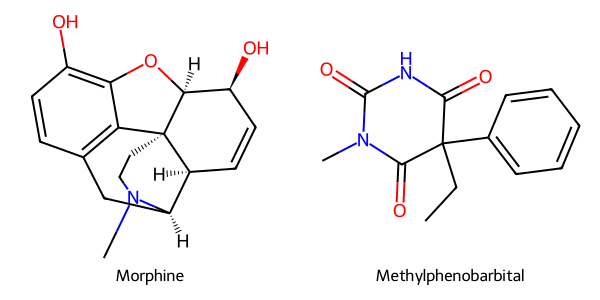

In [17]:
morphine_smiles = compounds[compounds['Name'] == 'Morphine']['SMILES_Canonical'].values[0]
methylphenobarbital_smiles = compounds[compounds['Name'] == 'Methylphenobarbital']['SMILES_Canonical'].values[0]

morphine_mol = Chem.MolFromSmiles(morphine_smiles)
methylphenobarbital_mol = Chem.MolFromSmiles(methylphenobarbital_smiles)

Draw.MolsToGridImage([morphine_mol, methylphenobarbital_mol], molsPerRow=2, subImgSize=(300,300), legends=["Morphine", "Methylphenobarbital"])


## Exercises

- Repeat the chemical similarity search for Morphine using a different canonicalization.

- Try the search procedure with a different molecule.

- Compare embedding distance to Tanimoto similarity using Morgan fingerprints.

- Redo the search with a different model checkpoint: `"seyonec/ChemBERTa-zinc-base-v1"`  
  Pre-calculated embeddings are available in file: `"data/Canonical_SMILES_embeddings_zinc.parquet"`  
  (See also notebook `week14-preprocessing.ipynb`.)

